# Model training and prediction - `composite`

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
os.getcwd()

'/Users/ludvigwarnberggerdin/projects/ttris/pemett'

In [4]:
import pandas as pd

In [5]:
X_train = pd.read_csv("./data/processed/composite/X_train.csv", index_col = 0)
y_train = pd.read_csv("./data/processed/composite/y_train.csv", index_col = 0).composite
X_test = pd.read_csv("./data/processed/composite/X_test.csv", index_col = 0)
y_test = pd.read_csv("./data/processed/composite/y_test.csv", index_col = 0).composite

In [6]:
y_train.value_counts() / len(y_train.index) * 100

0    98.167497
1     1.832503
Name: composite, dtype: float64

In [7]:
cont_features = ["age", "hr", "sbp", "dbp", "spo2", "rr", "delay"]
cat_features = list(X_train.loc[:, ~X_train.columns.isin(cont_features)].columns)

## Run hyper parameter search

In [8]:
import random
import numpy as np

from tqdm.notebook import tqdm
from src.models.train_model import generate_all_combinations

In [9]:
import itertools as it
all_breaks = [(0, ) + x + (np.inf,) for x in it.combinations(np.arange(0.01, 1, 0.01), r=3)]

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [11]:
hyper_parameters = {
    "logisticregression__logisticregression__C": [0.1, 0.2],
    "randomforestclassifier__randomforestclassifier__n_estimators": [100, 200],
    "breaks": all_breaks[:1]
}

In [12]:
numerical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="median", add_indicator=True)),
    ("ss", StandardScaler())
])
categorical_pipeline = Pipeline(steps=[
    ("si", SimpleImputer(strategy="most_frequent", add_indicator=True)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])
transformers = [
    ("cont", numerical_pipeline, cont_features), 
    ("cat", categorical_pipeline, cat_features)]
preprocessor = ColumnTransformer(transformers=transformers)

In [13]:
lr = Pipeline(steps = [
    ("pp", preprocessor),
    ("logisticregression", LogisticRegression())
])
rf = Pipeline(steps = [
    ("pp", preprocessor),
    ("randomforestclassifier", RandomForestClassifier())
])
base_clfs = [
    lr,
    rf
]

In [14]:
all_hyper_parameters = generate_all_combinations(hyper_parameters)

In [15]:
from src.models.classifiers import StackedGeneralizationClassifier

In [27]:
sgclf = StackedGeneralizationClassifier(base_clfs = base_clfs, meta_clf = LogisticRegression(), verbose=False)

sgclf.cv_outer_loop(all_hyper_parameters = all_hyper_parameters, X = X_train, y = y_train, refit=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Outer loop, each fold:
	Number of 0's: ~3054 (98.17%)
	Number of 1's: ~57 (1.83%)
Inner loop, each loop:
	Number of 0's: ~1527 (98.17%)
	Number of 1's: ~28 (1.83%)


In [28]:
y_test_pred_con, y_test_pred_cut = sgclf.predict(X_test)

In [29]:
from sklearn.metrics import roc_auc_score

In [30]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_con, y_true = y_test)))

'Hold-out continous model: 0.5'

In [31]:
("Hold-out continous model: " + 
str(roc_auc_score(y_score = y_test_pred_cut, y_true = y_test)))

'Hold-out continous model: 0.5'

In [32]:
from src.visualization.visualize import plot_roc, plot_precision_recall

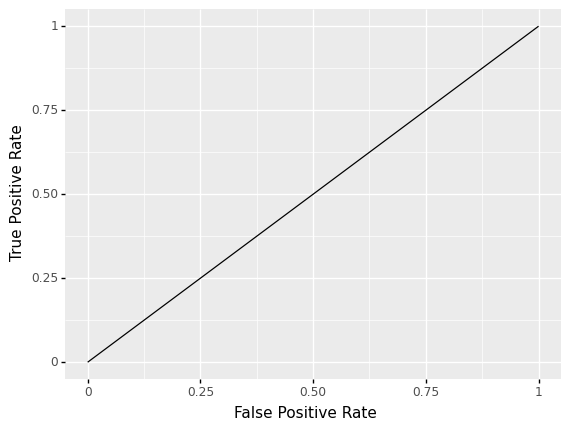

<ggplot: (369001391)>

In [33]:
plot_roc(y_test, y_test_pred_con)

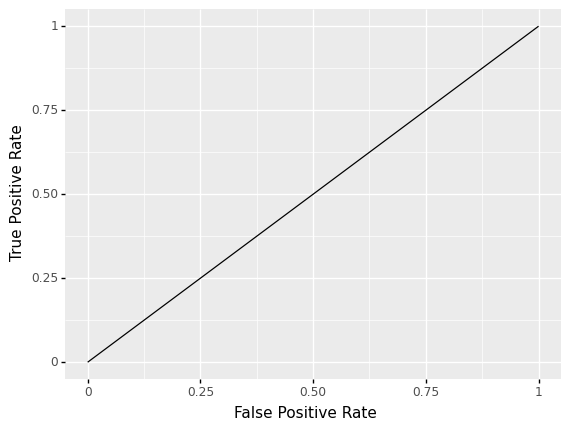

<ggplot: (369001190)>

In [34]:
plot_roc(y_test, y_test_pred_cut)

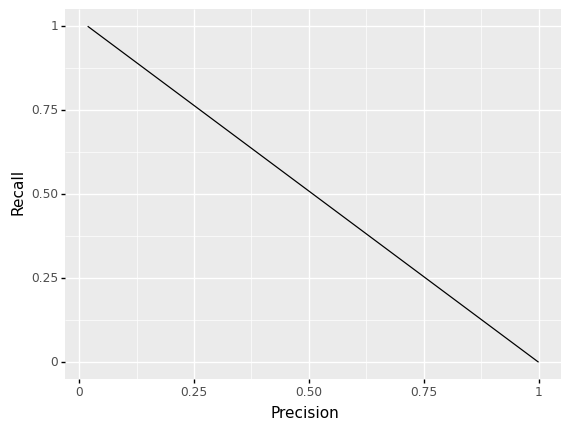

<ggplot: (369030051)>

In [35]:
plot_precision_recall(y_test, y_test_pred_con)

Plot roc curves for each classifier

In [36]:
from src.visualization.visualize import plot_roc_base_clfs

In [37]:
y_test_pred_clfs = sgclf.predict_meta_features(X_test)

In [38]:
keys = [
    clf.get_params()["steps"][-1][1].__class__.__name__ 
    for clf in sgclf.base_clfs_
]

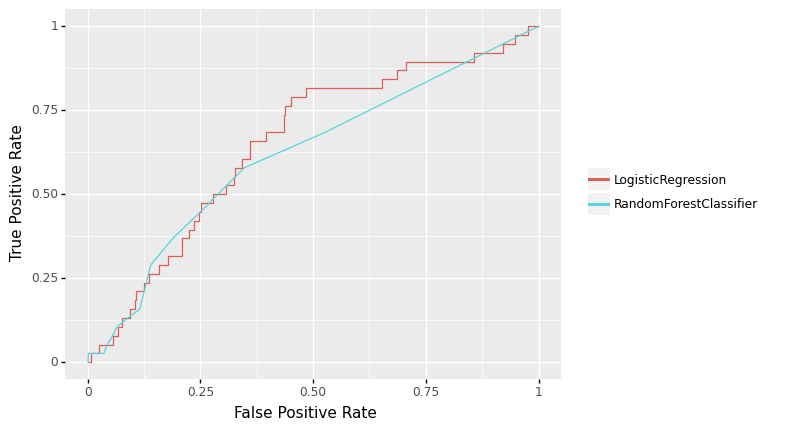

<ggplot: (369190837)>

In [40]:
plot_roc_base_clfs(y_test_pred_clfs, y_test, keys)